---
## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')

# Create plots directory
PLOTS_DIR = '/home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended/'
os.makedirs(PLOTS_DIR, exist_ok=True)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
plt.style.use('seaborn-v0_8-whitegrid')

# Preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Anomaly Detection Methods
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import mahalanobis
from scipy import stats

# Clustering
from sklearn.cluster import KMeans, DBSCAN
import hdbscan

# Classification for cross-validation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

# Deep Learning for Autoencoder
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, Model
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow not available. Autoencoder method will be skipped.")

# Utilities
from collections import Counter
from datetime import datetime
import json

print("All imports successful!")
print(f"TensorFlow available: {TF_AVAILABLE}")
print(f"UMAP available: {UMAP_AVAILABLE}")
print(f"Plots will be saved to: {os.path.abspath(PLOTS_DIR)}")

2026-01-17 16:45:24.275973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All imports successful!
TensorFlow available: True
UMAP available: True
Plots will be saved to: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended


---
## 1. Load and Explore Anomaly Dataset

In [2]:
# Load the anomaly dataset
anomaly_df = pd.read_csv('/home/smotaali/BGP_Traffic_Generation/RIPE/RIPE_INCIDENTS_EXTENDED/all_incidents_anomalies_extended.csv')

print("="*60)
print("ANOMALY DATASET OVERVIEW")
print("="*60)
print(f"Total samples: {len(anomaly_df):,}")
print(f"Features: {anomaly_df.shape[1]}")
print(f"\nColumns: {list(anomaly_df.columns)}")

ANOMALY DATASET OVERVIEW
Total samples: 185,586
Features: 31

Columns: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps', 'label', 'Incident', 'window_start', 'window_end']


In [3]:
# Display first few rows
anomaly_df.head()

,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,rare_ases_avg,nadas,flaps,label,Incident,window_start,window_end
0,96,1,76,0,96,0,0,0,0,0,...,0,0,21,0.039326,1,0,dos_attack,BGP Route Oscillation Event,2015-06-12 08:00:00,2015-06-12 08:00:01
1,678,26,510,3,670,8,0,31,6,25,...,0,5,53,0.012450,4,0,dos_attack,BGP Route Oscillation Event,2015-06-12 08:00:16,2015-06-12 08:00:17
2,2664,234,722,164,2642,22,5,886,357,529,...,0,124,57,0.003759,120,0,dos_attack,BGP Route Oscillation Event,2015-06-12 08:00:17,2015-06-12 08:00:18
3,8,7,5,0,8,0,0,1,0,1,...,0,0,9,0.136364,0,0,dos_attack,BGP Route Oscillation Event,2015-06-12 08:00:18,2015-06-12 08:00:19
4,390,20,301,0,385,5,1,36,10,26,...,0,3,69,0.026538,5,0,dos_attack,BGP Route Oscillation Event,2015-06-12 08:00:20,2015-06-12 08:00:21



LABEL DISTRIBUTION:
----------------------------------------
  dos_attack: 176,216 (95.0%)
  path_manipulation: 8,236 (4.4%)
  prefix_hijacking: 1,134 (0.6%)

Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//01_anomaly_type_distribution.png


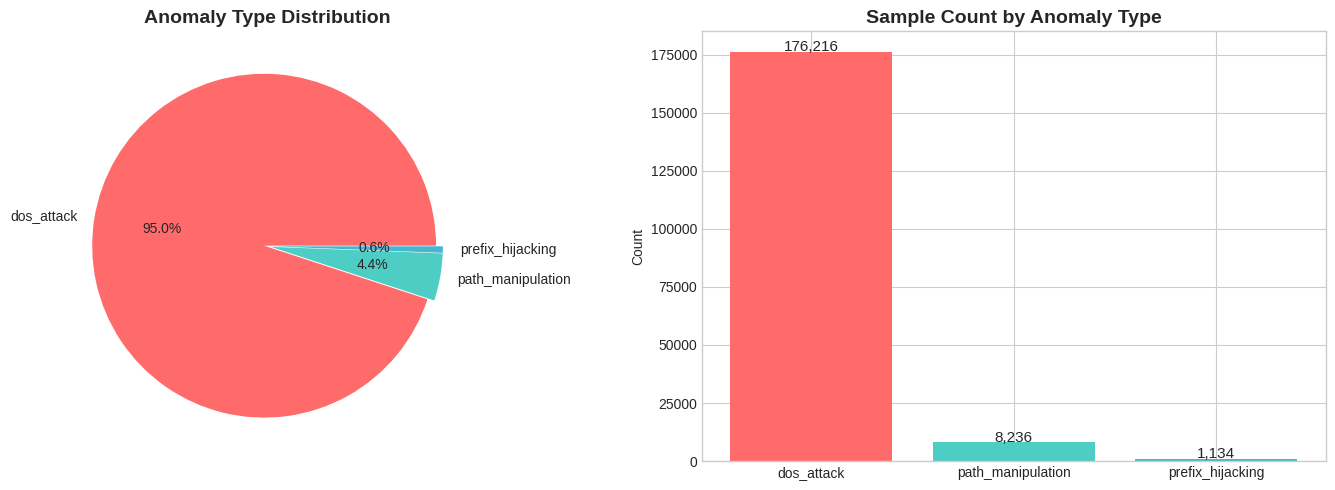

In [4]:
# Label distribution
print("\nLABEL DISTRIBUTION:")
print("-"*40)
label_counts = anomaly_df['label'].value_counts()
for label, count in label_counts.items():
    pct = count / len(anomaly_df) * 100
    print(f"  {label}: {count:,} ({pct:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            colors=colors, explode=[0.02]*len(label_counts))
axes[0].set_title('Anomaly Type Distribution', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(label_counts.index, label_counts.values, color=colors)
axes[1].set_title('Sample Count by Anomaly Type', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
for bar, count in zip(bars, label_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
                 f'{count:,}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/01_anomaly_type_distribution.png', dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {PLOTS_DIR}/01_anomaly_type_distribution.png")
plt.show()

In [5]:
# Incident distribution
print("\nINCIDENT DISTRIBUTION:")
print("-"*60)
incident_counts = anomaly_df['Incident'].value_counts()
for incident, count in incident_counts.head(15).items():
    label = anomaly_df[anomaly_df['Incident'] == incident]['label'].iloc[0]
    print(f"  {incident}: {count:,} samples [{label}]")
if len(incident_counts) > 15:
    print(f"  ... and {len(incident_counts) - 15} more incidents")


INCIDENT DISTRIBUTION:
------------------------------------------------------------
  MikroTik Botnet BGP Manipulation: 86,036 samples [dos_attack]
  Dyn DNS DDoS (Mirai Botnet): 26,651 samples [dos_attack]
  Blaster Worm BGP Impact: 23,003 samples [dos_attack]
  BGP Route Oscillation Event: 14,121 samples [dos_attack]
  Prefix Deaggregation Attack: 11,204 samples [dos_attack]
  Abnormal Global RIB Growth: 9,598 samples [dos_attack]
  CenturyLink Major Route Leak: 6,126 samples [path_manipulation]
  Conficker Worm BGP Impact: 4,969 samples [dos_attack]
  Hurricane Electric Route Leak: 1,411 samples [path_manipulation]
  Indosat-Google Hijack 2014: 1,017 samples [prefix_hijacking]
  GitHub Memcached DDoS Attack: 541 samples [dos_attack]
  Cogent Major Route Leak: 420 samples [path_manipulation]
  Tata Communications Route Leak: 160 samples [path_manipulation]
  Facebook/Meta Global Outage: 91 samples [dos_attack]
  Telia-Google Traffic Hijack: 81 samples [prefix_hijacking]
  ... and 9 

---
## 2. Feature Preparation

In [6]:
# Define feature columns (exclude metadata columns)
metadata_cols = ['label', 'Incident', 'window_start', 'window_end']
feature_cols = [col for col in anomaly_df.columns if col not in metadata_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

Feature columns (27):
['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps']


In [7]:
# Extract features and handle missing values
X = anomaly_df[feature_cols].copy()
y_label = anomaly_df['label'].copy()
y_incident = anomaly_df['Incident'].copy()

# Check for missing values
missing = X.isnull().sum()
if missing.sum() > 0:
    print("Missing values found:")
    print(missing[missing > 0])
    X = X.fillna(X.median())
else:
    print("No missing values found.")

# Check for infinite values
inf_mask = np.isinf(X.values)
if inf_mask.any():
    print(f"\nInfinite values found: {inf_mask.sum()}")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"\nFeature matrix shape: {X.shape}")

No missing values found.

Feature matrix shape: (185586, 27)


In [8]:
# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

print("Features normalized with RobustScaler")
print(f"Scaled feature statistics:")
print(f"  Mean range: [{X_scaled.mean(axis=0).min():.3f}, {X_scaled.mean(axis=0).max():.3f}]")
print(f"  Std range: [{X_scaled.std(axis=0).min():.3f}, {X_scaled.std(axis=0).max():.3f}]")

Features normalized with RobustScaler
Scaled feature statistics:
  Mean range: [0.000, 4.513]
  Std range: [0.004, 56.619]


---
## 3. Baseline Normal Profile Construction

Using real normal traffic data from RIPE RRC collectors with `likely_normal` labels.

In [9]:
class NormalBaselineProfile:
    """Constructs a statistical profile of normal BGP traffic from real data."""
    
    def __init__(self):
        self.fitted = False
        self.mean_ = None
        self.cov_ = None
        self.cov_inv_ = None
        self.n_samples_ = 0
        self.feature_names_ = None
        self.source_files_ = []
    
    def fit_from_data(self, normal_data, feature_names=None):
        """Fit baseline from actual normal traffic data."""
        self.mean_ = np.mean(normal_data, axis=0)
        self.cov_ = np.cov(normal_data.T)
        if self.cov_.ndim == 0:
            self.cov_ = np.array([[self.cov_]])
        try:
            self.cov_inv_ = np.linalg.pinv(self.cov_)
        except:
            self.cov_inv_ = np.eye(normal_data.shape[1])
        self.n_samples_ = len(normal_data)
        self.feature_names_ = feature_names
        self.fitted = True
        return self
    
    def mahalanobis_distance(self, X):
        """Calculate Mahalanobis distance from normal baseline."""
        if not self.fitted:
            raise ValueError("Profile not fitted.")
        distances = []
        for x in X:
            try:
                d = mahalanobis(x, self.mean_, self.cov_inv_)
            except:
                d = np.sqrt(np.sum((x - self.mean_)**2))
            distances.append(d)
        return np.array(distances)
    
    def get_statistics(self):
        if not self.fitted:
            return None
        return {
            'n_samples': self.n_samples_,
            'n_features': len(self.mean_),
            'mean_range': (self.mean_.min(), self.mean_.max()),
            'source_files': self.source_files_
        }


def load_real_normal_data(file_paths, target_label='likely_normal', feature_cols=None):
    """Load real normal traffic data from multiple files."""
    all_normal_data = []
    loaded_files = []
    common_features = None
    
    print("="*70)
    print("LOADING REAL NORMAL TRAFFIC DATA")
    print("="*70)
    print(f"Target label: '{target_label}'")
    print(f"Files to load: {len(file_paths)}")
    print("-"*70)
    
    for path in file_paths:
        try:
            print(f"\nLoading: {path}")
            df = pd.read_csv(path)
            print(f"  Total rows: {len(df):,}")
            
            # Check for label column - prioritize discovered_label
            label_col = None
            for col in ['discovered_label', 'label', 'Label', 'LABEL']:
                if col in df.columns:
                    label_col = col
                    break
            
            if label_col is None:
                print(f"  WARNING: No label column found. Skipping file.")
                continue
            
            print(f"  Label column: '{label_col}'")
            print(f"  Available labels: {df[label_col].unique().tolist()}")
            
            # Filter for target label
            normal_samples = df[df[label_col] == target_label]
            print(f"  Samples with '{target_label}': {len(normal_samples):,}")
            
            if len(normal_samples) == 0:
                normal_samples = df[df[label_col].str.lower().str.contains('likely_normal', na=False)]
                print(f"  (Case-insensitive match): {len(normal_samples):,}")
            
            if len(normal_samples) < 10:
                print(f"  WARNING: Too few samples. Skipping file.")
                continue
            
            # Determine features
            if feature_cols is not None:
                available_features = [f for f in feature_cols if f in normal_samples.columns]
            else:
                exclude_cols = ['label', 'Label', 'discovered_label', 'LABEL', 
                               'window_start', 'window_end', 'Incident', 'incident',
                               'timestamp', 'Timestamp', 'file', 'File']
                available_features = [col for col in normal_samples.columns 
                                     if col not in exclude_cols and 
                                     normal_samples[col].dtype in ['int64', 'float64']]
            
            if common_features is None:
                common_features = available_features
            else:
                common_features = [f for f in common_features if f in available_features]
            
            print(f"  Available features: {len(available_features)}")
            X_normal = normal_samples[available_features].values
            X_normal = np.nan_to_num(X_normal, nan=0.0, posinf=0.0, neginf=0.0)
            
            all_normal_data.append((X_normal, available_features, path))
            loaded_files.append(path)
            print(f"  SUCCESS: Loaded {len(normal_samples):,} normal samples")
            
        except FileNotFoundError:
            print(f"  ERROR: File not found: {path}")
        except Exception as e:
            print(f"  ERROR: {str(e)}")
    
    if len(all_normal_data) == 0:
        print("\nERROR: No normal data could be loaded!")
        return None, None, []
    
    print("\n" + "-"*70)
    print("COMBINING DATA FROM ALL SOURCES")
    print("-"*70)
    print(f"Common features across all files: {len(common_features)}")
    
    combined_data = []
    for X, features, path in all_normal_data:
        feature_indices = [features.index(f) for f in common_features if f in features]
        if len(feature_indices) == len(common_features):
            X_common = X[:, feature_indices]
            combined_data.append(X_common)
            print(f"  {path.split('/')[-1]}: {len(X_common):,} samples")
    
    if len(combined_data) == 0:
        return None, None, []
    
    normal_data = np.vstack(combined_data)
    print(f"\nTotal combined normal samples: {len(normal_data):,}")
    print(f"Feature dimensions: {normal_data.shape[1]}")
    
    return normal_data, common_features, loaded_files


# Load real normal traffic data
normal_data_paths = [
    '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc04_updates_20251116_extracted_discovered.csv',
    '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_discovered.csv',
]

normal_data, common_features, loaded_files = load_real_normal_data(
    file_paths=normal_data_paths,
    target_label='likely_normal',
    feature_cols=feature_cols
)

# Initialize baseline
normal_baseline = NormalBaselineProfile()

if normal_data is not None and len(normal_data) > 0:
    normal_data_scaled = scaler.transform(
        pd.DataFrame(normal_data, columns=common_features)[feature_cols].values
    ) if set(feature_cols).issubset(set(common_features)) else scaler.fit_transform(normal_data)
    
    normal_baseline.fit_from_data(normal_data_scaled, feature_names=common_features)
    normal_baseline.source_files_ = loaded_files
    
    print("\n" + "="*70)
    print("NORMAL BASELINE PROFILE - SUCCESSFULLY FITTED")
    print("="*70)
    stats = normal_baseline.get_statistics()
    print(f"  Total normal samples: {stats['n_samples']:,}")
    print(f"  Features used: {stats['n_features']}")
else:
    print("\nWARNING: Could not load real normal data!")

LOADING REAL NORMAL TRAFFIC DATA
Target label: 'likely_normal'
Files to load: 2
----------------------------------------------------------------------

Loading: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc04_updates_20251116_extracted_discovered.csv


  Total rows: 86,387
  Label column: 'discovered_label'
  Available labels: ['likely_anomaly', 'likely_normal', 'uncertain', 'high_confidence_anomaly']
  Samples with 'likely_normal': 67,940
  Available features: 27
  SUCCESS: Loaded 67,940 normal samples

Loading: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_discovered.csv
  Total rows: 86,400
  Label column: 'discovered_label'
  Available labels: ['likely_normal', 'uncertain', 'high_confidence_anomaly', 'likely_anomaly']
  Samples with 'likely_normal': 65,819
  Available features: 27
  SUCCESS: Loaded 65,819 normal samples

----------------------------------------------------------------------
COMBINING DATA FROM ALL SOURCES
----------------------------------------------------------------------
Common features across all files: 27
  rrc04_updates_20251116_extracted_discovered.csv: 67,940 samples
  rrc05_updates_20251216_extracted_discovered.csv: 65,819 samples

Total 


NORMAL vs ANOMALY FEATURE COMPARISON


Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//02_normal_vs_anomaly_features.png


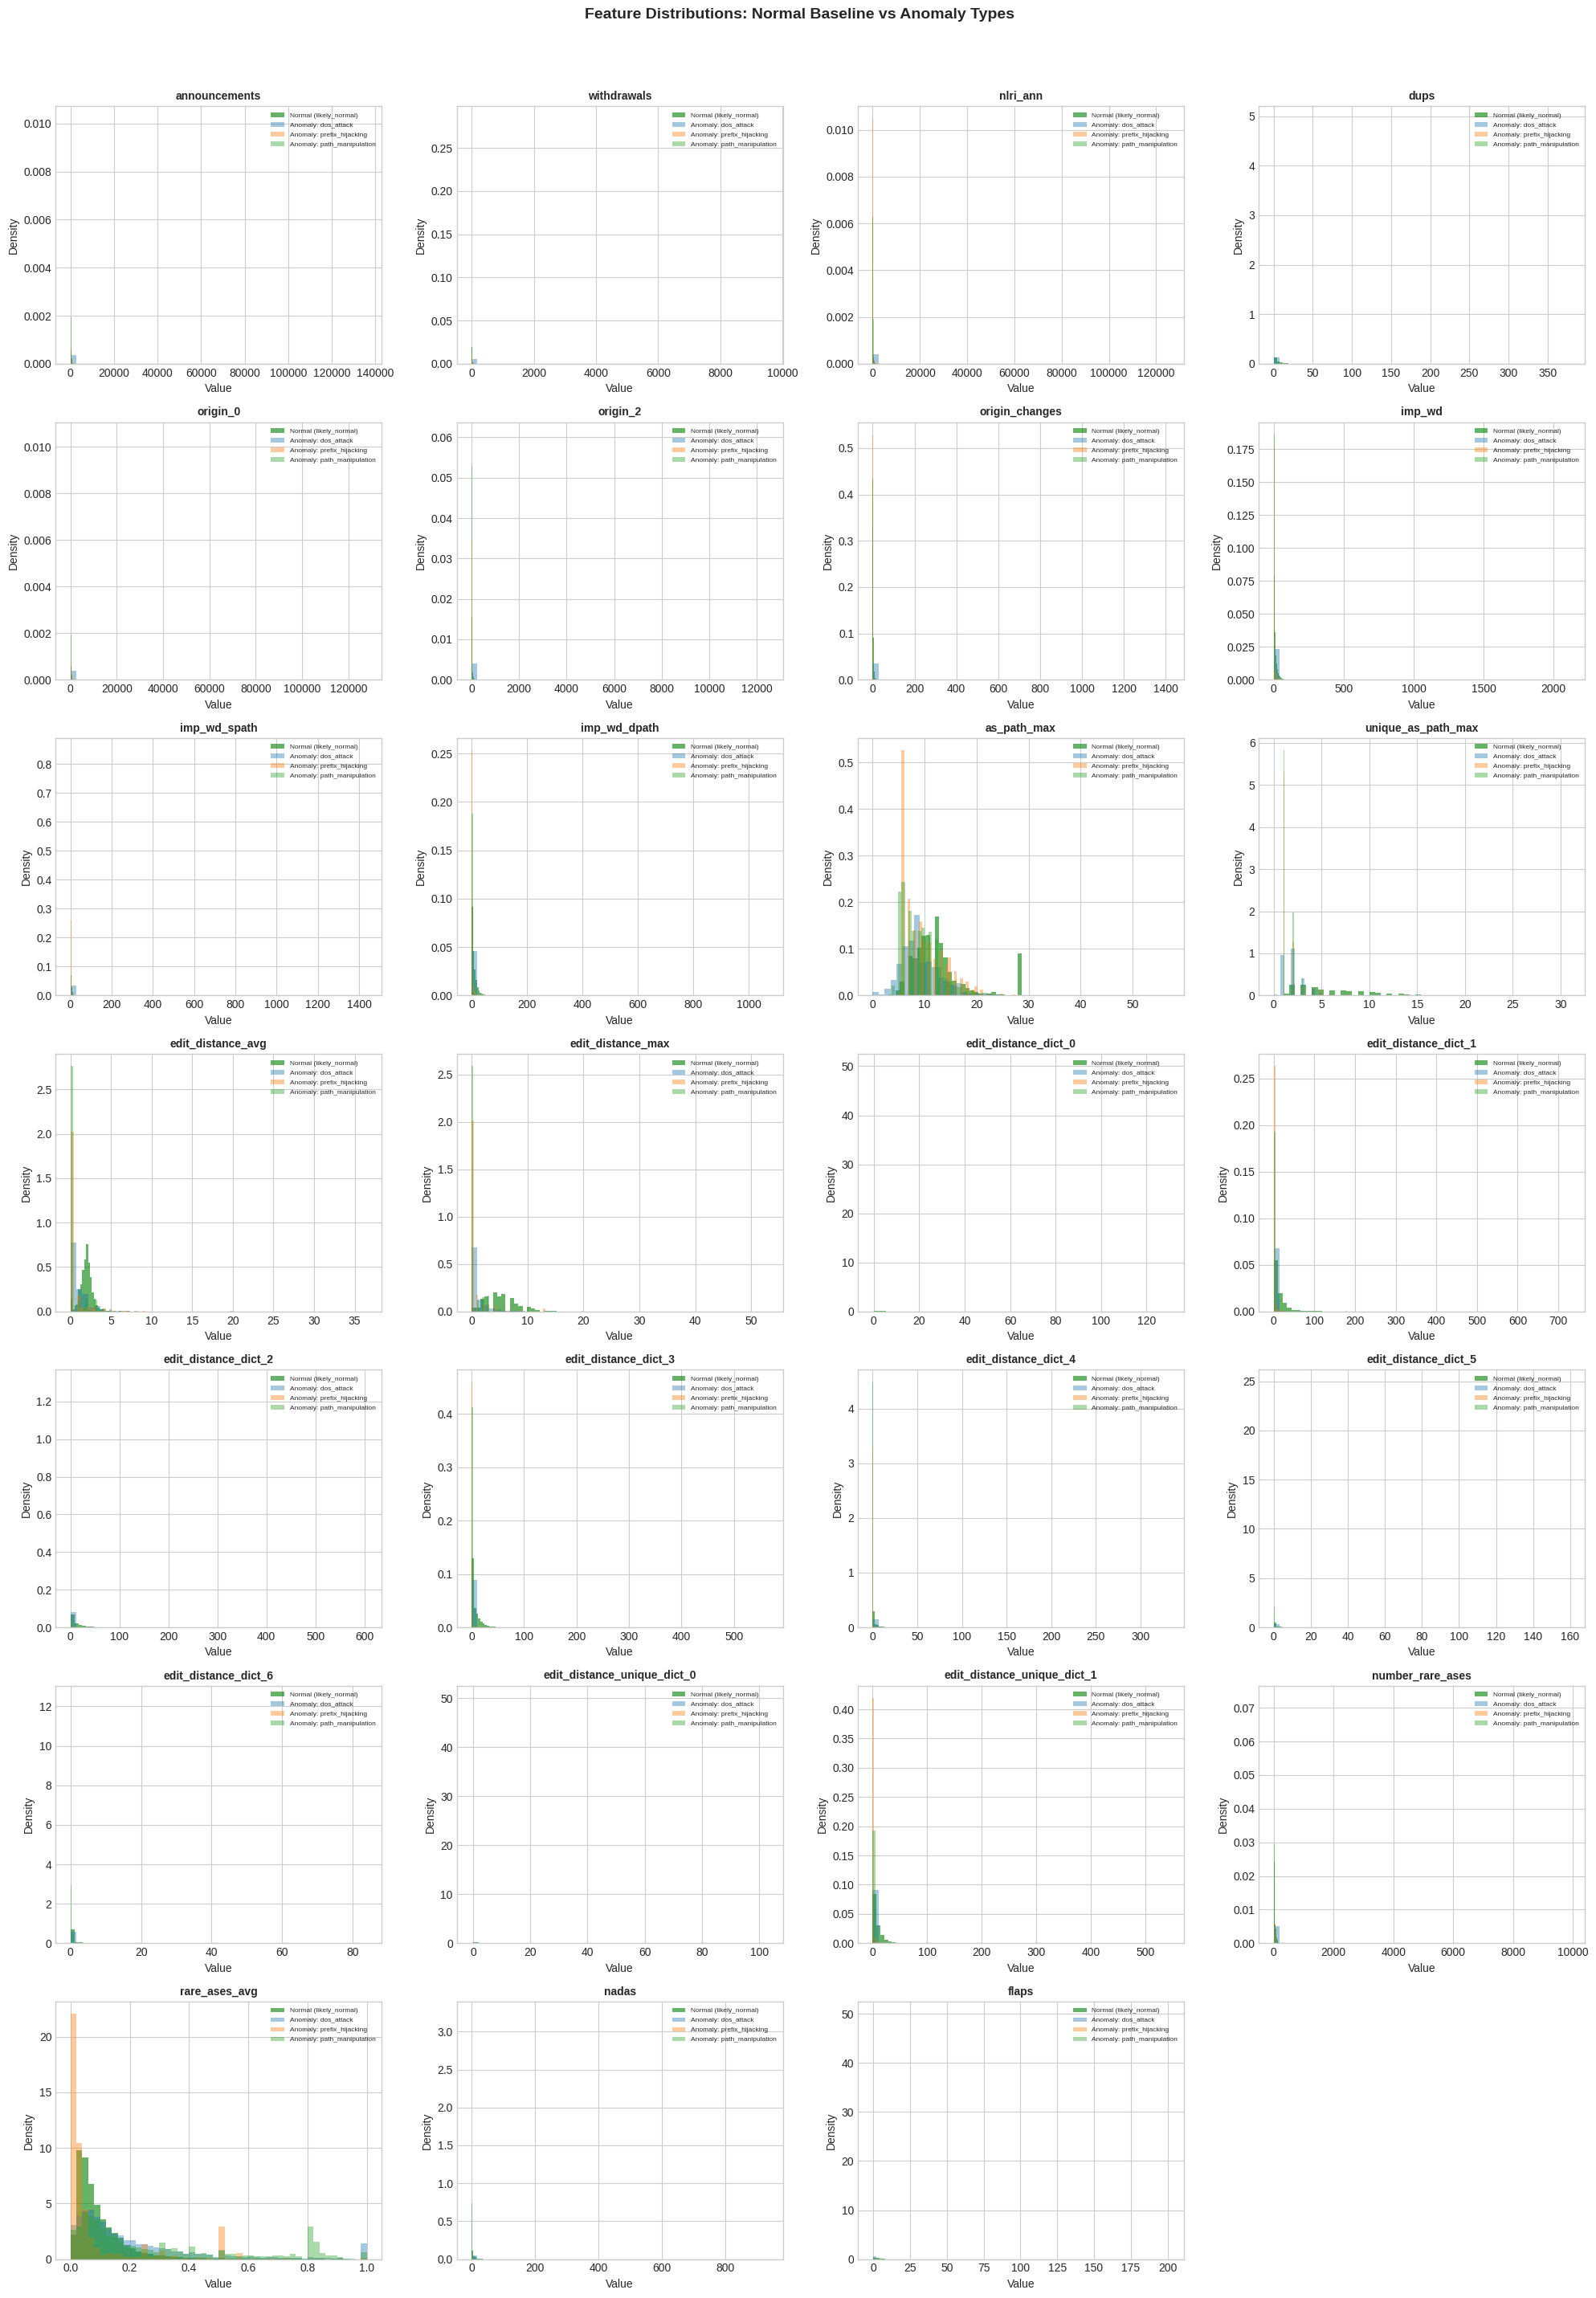


Feature Statistics Comparison:
----------------------------------------------------------------------
Feature                    Normal Mean   Normal Std Anomaly Mean  Anomaly Std
----------------------------------------------------------------------
announcements                   150.18       198.39       128.80      1585.56
withdrawals                      12.46        30.18         8.47        63.21
nlri_ann                        150.18       198.39       119.51      1527.83
dups                              6.70        10.35         0.06         1.46
origin_0                        136.12       190.01       119.59      1486.76
origin_2                         13.65        24.77         9.03       113.24
origin_changes                    2.23         3.98         0.43         8.21
imp_wd                           12.70        15.22         2.86        16.09
imp_wd_spath                      3.57         5.50         0.63         8.85
imp_wd_dpath                      9.13        

In [10]:
# Visualize Normal Baseline vs Anomaly Data Distribution
if normal_baseline.fitted and normal_data is not None:
    print("\nNORMAL vs ANOMALY FEATURE COMPARISON")
    print("="*70)
    
    features_to_plot = [f for f in common_features if f in feature_cols]
    n_features = len(features_to_plot)
    
    if n_features >= 1:
        n_cols = 4
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
        axes = axes.flatten() if n_features > 1 else [axes]
        
        for idx, feat in enumerate(features_to_plot):
            ax = axes[idx]
            feat_idx_anomaly = feature_cols.index(feat) if feat in feature_cols else None
            feat_idx_normal = common_features.index(feat) if feat in common_features else None
            
            if feat_idx_anomaly is not None and feat_idx_normal is not None:
                normal_vals = normal_data[:, feat_idx_normal]
                ax.hist(normal_vals, bins=50, alpha=0.6, label='Normal (likely_normal)', 
                       color='green', density=True)
                
                for label in y_label.unique():
                    mask = y_label == label
                    anomaly_vals = X.values[mask, feat_idx_anomaly]
                    ax.hist(anomaly_vals, bins=50, alpha=0.4, label=f'Anomaly: {label}', 
                           density=True)
                
                ax.set_title(f'{feat}', fontsize=10, fontweight='bold')
                ax.set_xlabel('Value')
                ax.set_ylabel('Density')
                ax.legend(fontsize=6)
        
        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('Feature Distributions: Normal Baseline vs Anomaly Types', 
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig(f'{PLOTS_DIR}/02_normal_vs_anomaly_features.png', dpi=150, bbox_inches='tight')
        print(f"Plot saved: {PLOTS_DIR}/02_normal_vs_anomaly_features.png")
        plt.show()
        
        # Statistics comparison
        print("\nFeature Statistics Comparison:")
        print("-"*70)
        print(f"{'Feature':<25} {'Normal Mean':>12} {'Normal Std':>12} {'Anomaly Mean':>12} {'Anomaly Std':>12}")
        print("-"*70)
        
        for feat in features_to_plot[:15]:
            feat_idx_anomaly = feature_cols.index(feat) if feat in feature_cols else None
            feat_idx_normal = common_features.index(feat) if feat in common_features else None
            if feat_idx_anomaly is not None and feat_idx_normal is not None:
                normal_mean = normal_data[:, feat_idx_normal].mean()
                normal_std = normal_data[:, feat_idx_normal].std()
                anomaly_mean = X.iloc[:, feat_idx_anomaly].mean()
                anomaly_std = X.iloc[:, feat_idx_anomaly].std()
                print(f"{feat:<25} {normal_mean:>12.2f} {normal_std:>12.2f} {anomaly_mean:>12.2f} {anomaly_std:>12.2f}")

---
## 4. Anomaly Deviation Scoring (6 Methods)

In [11]:
class AnomalyReinforcementScorer:
    """Ensemble anomaly reinforcement scoring using multiple methods."""
    
    def __init__(self, normal_baseline=None):
        self.normal_baseline = normal_baseline
        self.scores = {}
        self.models = {}
        self.binary_flags = {}  # Store binary anomaly flags for method agreement
    
    def score_mahalanobis(self, X):
        print("[1/6] Computing Mahalanobis distances...")
        if self.normal_baseline is not None and self.normal_baseline.fitted:
            distances = self.normal_baseline.mahalanobis_distance(X)
        else:
            mean = X.mean(axis=0)
            cov = np.cov(X.T)
            try:
                cov_inv = np.linalg.pinv(cov)
                distances = np.array([mahalanobis(x, mean, cov_inv) for x in X])
            except:
                distances = np.sqrt(np.sum((X - mean)**2, axis=1))
        
        self.scores['mahalanobis'] = self._normalize_scores(distances)
        # Flag as anomaly if distance > median + 1.5*IQR
        q75, q25 = np.percentile(distances, [75, 25])
        threshold = q75 + 1.5 * (q75 - q25)
        self.binary_flags['mahalanobis'] = (distances > threshold).astype(int)
        return self.scores['mahalanobis']
    
    def score_one_class_svm(self, X):
        print("[2/6] Fitting One-Class SVM...")
        if len(X) > 10000:
            np.random.seed(42)
            sample_idx = np.random.choice(len(X), 10000, replace=False)
            X_train = X[sample_idx]
        else:
            X_train = X
        
        ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
        ocsvm.fit(X_train)
        self.models['ocsvm'] = ocsvm
        
        decision = -ocsvm.decision_function(X)
        self.scores['ocsvm'] = self._normalize_scores(decision)
        self.binary_flags['ocsvm'] = (ocsvm.predict(X) == -1).astype(int)
        return self.scores['ocsvm']
    
    def score_statistical(self, X):
        print("[3/6] Computing statistical z-scores...")
        mean = X.mean(axis=0)
        std = X.std(axis=0) + 1e-10
        z_scores = np.abs((X - mean) / std)
        
        max_z = z_scores.max(axis=1)
        extreme_count = (z_scores > 3).sum(axis=1)
        combined = max_z + extreme_count * 0.5
        
        self.scores['statistical'] = self._normalize_scores(combined)
        self.binary_flags['statistical'] = (max_z > 3).astype(int)
        return self.scores['statistical']
    
    def score_lof(self, X):
        print("[4/6] Computing Local Outlier Factor...")
        n_neighbors = min(int(np.sqrt(len(X))), 50)
        n_neighbors = max(n_neighbors, 10)
        
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1, novelty=False)
        predictions = lof.fit_predict(X)
        
        lof_scores = -lof.negative_outlier_factor_
        self.scores['lof'] = self._normalize_scores(lof_scores)
        self.binary_flags['lof'] = (predictions == -1).astype(int)
        return self.scores['lof']
    
    def score_isolation_forest(self, X):
        print("[5/6] Fitting Isolation Forest...")
        iso_forest = IsolationForest(n_estimators=200, contamination=0.1, 
                                      random_state=42, n_jobs=-1)
        predictions = iso_forest.fit_predict(X)
        self.models['isolation_forest'] = iso_forest
        
        iso_scores = -iso_forest.score_samples(X)
        self.scores['isolation_forest'] = self._normalize_scores(iso_scores)
        self.binary_flags['isolation_forest'] = (predictions == -1).astype(int)
        return self.scores['isolation_forest']
    
    def score_elliptic_envelope(self, X):
        print("[6/6] Fitting Elliptic Envelope...")
        try:
            ee = EllipticEnvelope(contamination=0.1, random_state=42)
            predictions = ee.fit_predict(X)
            self.models['elliptic_envelope'] = ee
            
            ee_scores = -ee.decision_function(X)
            self.scores['elliptic_envelope'] = self._normalize_scores(ee_scores)
            self.binary_flags['elliptic_envelope'] = (predictions == -1).astype(int)
        except Exception as e:
            print(f"  Warning: Elliptic Envelope failed ({e}), using fallback")
            self.scores['elliptic_envelope'] = np.zeros(len(X))
            self.binary_flags['elliptic_envelope'] = np.zeros(len(X), dtype=int)
        return self.scores['elliptic_envelope']
    
    def _normalize_scores(self, scores):
        scores = np.array(scores)
        min_s, max_s = scores.min(), scores.max()
        if max_s - min_s > 0:
            return (scores - min_s) / (max_s - min_s)
        return np.zeros_like(scores)
    
    def compute_all_scores(self, X):
        print("="*60)
        print("COMPUTING ANOMALY REINFORCEMENT SCORES")
        print("="*60)
        
        self.score_mahalanobis(X)
        self.score_one_class_svm(X)
        self.score_statistical(X)
        self.score_lof(X)
        self.score_isolation_forest(X)
        self.score_elliptic_envelope(X)
        
        print("\nAll scores computed.")
        return self.scores
    
    def get_method_agreement(self):
        """Count how many methods flag each sample as anomaly."""
        if not self.binary_flags:
            raise ValueError("No scores computed.")
        
        agreement = np.zeros(len(list(self.binary_flags.values())[0]))
        for method, flags in self.binary_flags.items():
            agreement += flags
        return agreement
    
    def get_ensemble_score(self, weights=None):
        if not self.scores:
            raise ValueError("No scores computed.")
        if weights is None:
            weights = {k: 1.0 for k in self.scores.keys()}
        total_weight = sum(weights.values())
        ensemble = np.zeros(len(list(self.scores.values())[0]))
        for method, score in self.scores.items():
            w = weights.get(method, 1.0)
            ensemble += w * score
        return ensemble / total_weight


# Initialize scorer and compute all scores
scorer = AnomalyReinforcementScorer(normal_baseline=normal_baseline)
all_scores = scorer.compute_all_scores(X_scaled)

COMPUTING ANOMALY REINFORCEMENT SCORES
[1/6] Computing Mahalanobis distances...


[2/6] Fitting One-Class SVM...
[3/6] Computing statistical z-scores...
[4/6] Computing Local Outlier Factor...
[5/6] Fitting Isolation Forest...
[6/6] Fitting Elliptic Envelope...

All scores computed.


Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//03_anomaly_score_distributions.png


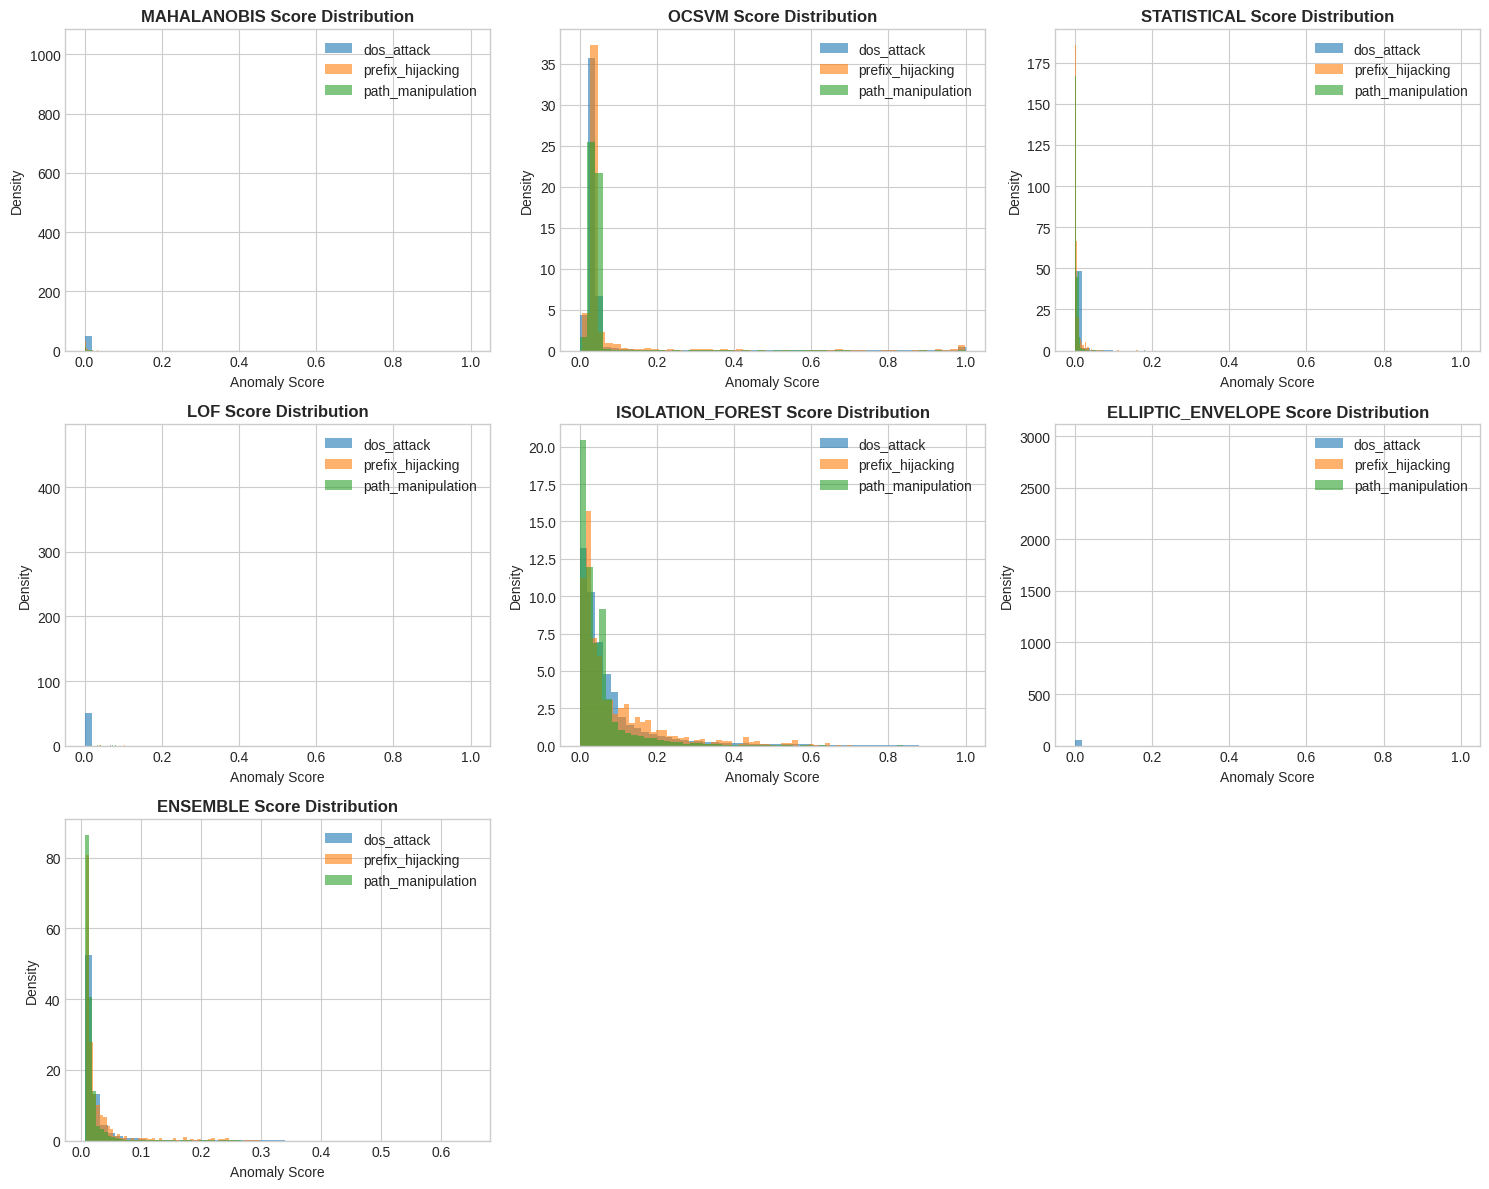

In [12]:
# Visualize score distributions
n_methods = len(all_scores)
n_cols = 3
n_rows = (n_methods + 1 + n_cols - 1) // n_cols  # +1 for ensemble

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, (method, scores) in enumerate(all_scores.items()):
    ax = axes[i]
    for label in y_label.unique():
        mask = y_label == label
        ax.hist(scores[mask], bins=50, alpha=0.6, label=label, density=True)
    ax.set_title(f'{method.upper()} Score Distribution', fontweight='bold')
    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Density')
    ax.legend()

# Ensemble score
ensemble_score = scorer.get_ensemble_score()
ax = axes[n_methods]
for label in y_label.unique():
    mask = y_label == label
    ax.hist(ensemble_score[mask], bins=50, alpha=0.6, label=label, density=True)
ax.set_title('ENSEMBLE Score Distribution', fontweight='bold')
ax.set_xlabel('Anomaly Score')
ax.set_ylabel('Density')
ax.legend()

# Hide empty
for idx in range(n_methods + 1, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/03_anomaly_score_distributions.png', dpi=150, bbox_inches='tight')
print(f"Plot saved: {PLOTS_DIR}/03_anomaly_score_distributions.png")
plt.show()


SCORE CORRELATION MATRIX:
Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//04_score_correlation_matrix.png


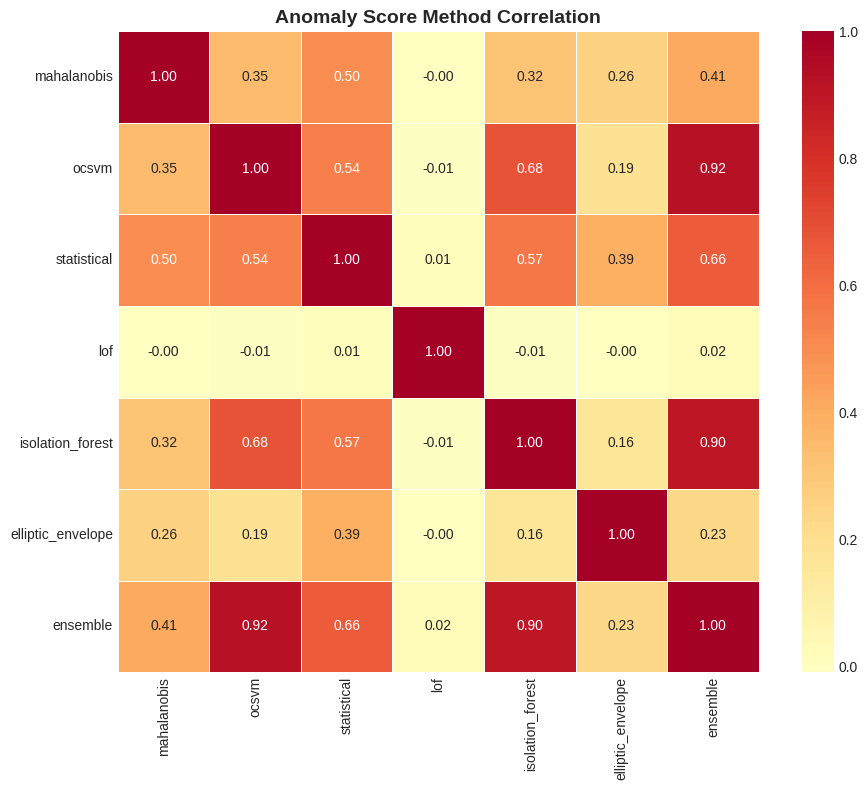

In [13]:
# Score correlation analysis
score_df = pd.DataFrame(all_scores)
score_df['ensemble'] = ensemble_score

print("\nSCORE CORRELATION MATRIX:")
corr_matrix = score_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Anomaly Score Method Correlation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/04_score_correlation_matrix.png', dpi=150, bbox_inches='tight')
print(f"Plot saved: {PLOTS_DIR}/04_score_correlation_matrix.png")
plt.show()

---
## 5. Method Agreement Based Confidence Assignment

Confidence is assigned based on **how many methods agree** that a sample is anomalous.

In [14]:
def assign_confidence_by_method_agreement(method_agreement, n_methods=6):
    """
    Assign confidence levels based on method agreement count.
    
    Confidence Levels:
    - very_high_confidence: 5-6 methods agree (>=83%)
    - high_confidence: 4 methods agree (67%)
    - medium_confidence: 3 methods agree (50%)
    - low_confidence: 2 methods agree (33%)
    - needs_review: 0-1 methods agree (<33%)
    """
    n_samples = len(method_agreement)
    confidence_labels = np.array(['needs_review'] * n_samples, dtype=object)
    
    # Assign based on agreement count
    confidence_labels[method_agreement >= 5] = 'very_high_confidence'
    confidence_labels[(method_agreement == 4)] = 'high_confidence'
    confidence_labels[(method_agreement == 3)] = 'medium_confidence'
    confidence_labels[(method_agreement == 2)] = 'low_confidence'
    # 0-1 remains 'needs_review'
    
    return confidence_labels


# Get method agreement
method_agreement = scorer.get_method_agreement()

# Assign confidence labels
confidence_labels = assign_confidence_by_method_agreement(method_agreement)

# Summary
print("\nMETHOD AGREEMENT DISTRIBUTION:")
print("="*60)
for i in range(7):
    count = (method_agreement == i).sum()
    pct = count / len(method_agreement) * 100
    print(f"  {i} methods agree: {count:,} ({pct:.1f}%)")

print("\nCONFIDENCE DISTRIBUTION (Method Agreement Based):")
print("="*60)
conf_counts = pd.Series(confidence_labels).value_counts()
for conf, count in conf_counts.items():
    pct = count / len(confidence_labels) * 100
    print(f"  {conf}: {count:,} ({pct:.1f}%)")


METHOD AGREEMENT DISTRIBUTION:
  0 methods agree: 135,999 (73.3%)
  1 methods agree: 21,121 (11.4%)
  2 methods agree: 9,668 (5.2%)
  3 methods agree: 7,939 (4.3%)
  4 methods agree: 3,725 (2.0%)
  5 methods agree: 4,157 (2.2%)
  6 methods agree: 2,977 (1.6%)

CONFIDENCE DISTRIBUTION (Method Agreement Based):
  needs_review: 157,120 (84.7%)
  low_confidence: 9,668 (5.2%)
  medium_confidence: 7,939 (4.3%)
  very_high_confidence: 7,134 (3.8%)
  high_confidence: 3,725 (2.0%)


Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//05_method_agreement_distribution.png


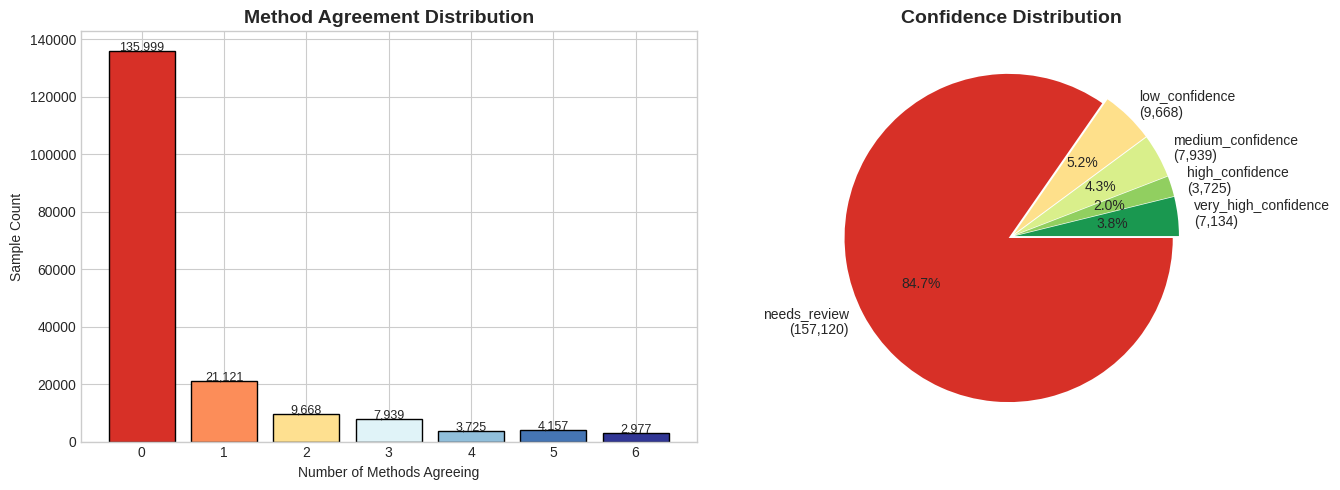

In [15]:
# Visualize method agreement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Method agreement histogram
ax = axes[0]
agreement_counts = [int((method_agreement == i).sum()) for i in range(7)]
colors_agree = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4', '#313695']
bars = ax.bar(range(7), agreement_counts, color=colors_agree, edgecolor='black')
ax.set_xlabel('Number of Methods Agreeing')
ax.set_ylabel('Sample Count')
ax.set_title('Method Agreement Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(range(7))
for bar, count in zip(bars, agreement_counts):
    if count > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                f'{count:,}', ha='center', fontsize=9)

# Confidence pie chart
ax = axes[1]
conf_order = ['very_high_confidence', 'high_confidence', 'medium_confidence', 
              'low_confidence', 'needs_review']
conf_colors = ['#1a9850', '#91cf60', '#d9ef8b', '#fee08b', '#d73027']
sizes = [conf_counts.get(c, 0) for c in conf_order]
labels_pie = [f"{c}\n({s:,})" for c, s in zip(conf_order, sizes) if s > 0]
sizes_filtered = [s for s in sizes if s > 0]
colors_filtered = [c for c, s in zip(conf_colors, sizes) if s > 0]

ax.pie(sizes_filtered, labels=labels_pie, colors=colors_filtered, autopct='%1.1f%%',
       explode=[0.02]*len(sizes_filtered))
ax.set_title('Confidence Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/05_method_agreement_distribution.png', dpi=150, bbox_inches='tight')
print(f"Plot saved: {PLOTS_DIR}/05_method_agreement_distribution.png")
plt.show()


CONFIDENCE vs ORIGINAL LABEL:
col_0              high_confidence  low_confidence  medium_confidence  \
label                                                                   
dos_attack                    3641            9343               7750   
path_manipulation               61             282                153   
prefix_hijacking                23              43                 36   
All                           3725            9668               7939   

col_0              needs_review  very_high_confidence     All  
label                                                          
dos_attack               148516                  6966  176216  
path_manipulation          7654                    86    8236  
prefix_hijacking            950                    82    1134  
All                      157120                  7134  185586  



Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//06_confidence_by_anomaly_type.png


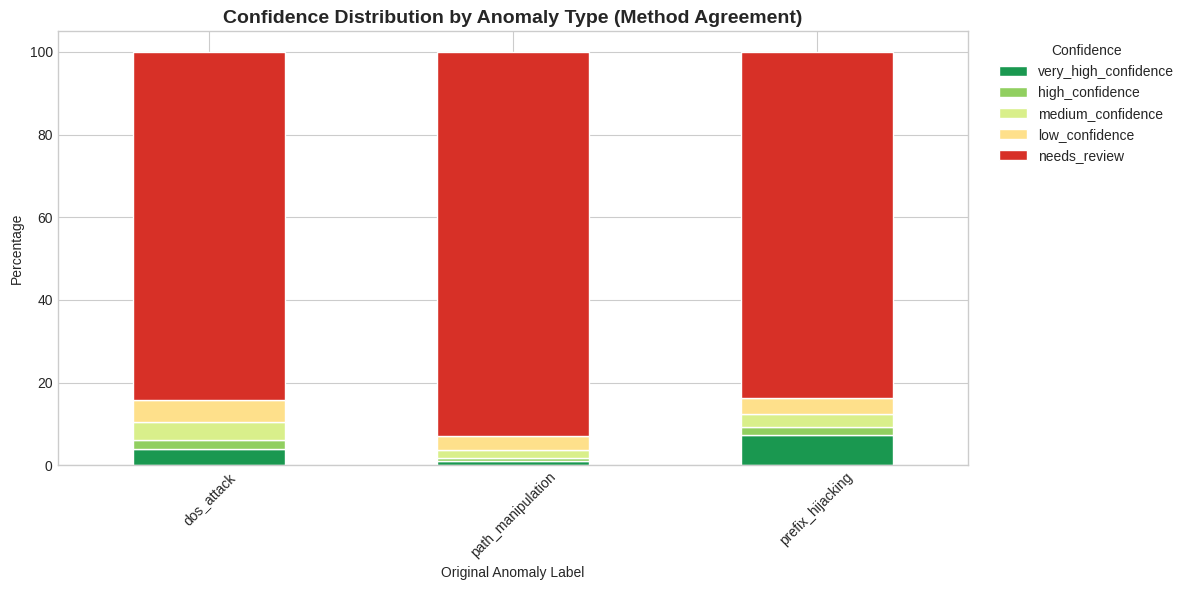

In [16]:
# Cross-tabulate confidence with original labels
print("\nCONFIDENCE vs ORIGINAL LABEL:")
print("="*60)
crosstab = pd.crosstab(y_label, confidence_labels, margins=True)
print(crosstab)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
crosstab_pct = pd.crosstab(y_label, confidence_labels, normalize='index') * 100

col_order = ['very_high_confidence', 'high_confidence', 'medium_confidence', 
             'low_confidence', 'needs_review']
crosstab_pct = crosstab_pct[[c for c in col_order if c in crosstab_pct.columns]]

crosstab_pct.plot(kind='bar', stacked=True, ax=ax, 
                  color=['#1a9850', '#91cf60', '#d9ef8b', '#fee08b', '#d73027'],
                  edgecolor='white')
ax.set_title('Confidence Distribution by Anomaly Type (Method Agreement)', fontsize=14, fontweight='bold')
ax.set_xlabel('Original Anomaly Label')
ax.set_ylabel('Percentage')
ax.legend(title='Confidence', bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/06_confidence_by_anomaly_type.png', dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {PLOTS_DIR}/06_confidence_by_anomaly_type.png")
plt.show()

---
## 6. Incident Coherence Validation

In [17]:
def compute_incident_coherence(X, incidents):
    unique_incidents = incidents.unique()
    coherence_results = []
    
    for incident in unique_incidents:
        mask = incidents == incident
        X_incident = X[mask]
        X_other = X[~mask]
        
        if len(X_incident) < 2:
            continue
        
        centroid = X_incident.mean(axis=0)
        intra_variance = np.mean(np.sum((X_incident - centroid)**2, axis=1))
        other_centroid = X_other.mean(axis=0) if len(X_other) > 0 else centroid
        inter_distance = np.sqrt(np.sum((centroid - other_centroid)**2))
        coherence = inter_distance / (np.sqrt(intra_variance) + 1e-10)
        
        coherence_results.append({
            'incident': incident,
            'n_samples': mask.sum(),
            'intra_variance': intra_variance,
            'inter_distance': inter_distance,
            'coherence_score': coherence
        })
    
    return pd.DataFrame(coherence_results)


coherence_df = compute_incident_coherence(X_scaled, y_incident)
coherence_df = coherence_df.sort_values('coherence_score', ascending=False)

print("\nINCIDENT COHERENCE SCORES:")
print("="*80)
print(f"{'Incident':<45} {'Samples':>8} {'Coherence':>12}")
print("-"*80)
for _, row in coherence_df.head(15).iterrows():
    print(f"{row['incident']:<45} {row['n_samples']:>8,} {row['coherence_score']:>12.2f}")


INCIDENT COHERENCE SCORES:
Incident                                       Samples    Coherence
--------------------------------------------------------------------------------
Bitcanal Serial Hijacker                             2        32.79
AWS US-East S3 Outage                                2        17.05
Excessive AS-Path Prepending Attack                  8         1.67
Turk Telecom DNS Hijack 2014                        12         1.64
Facebook/Meta Global Outage                         91         1.23
Telkom South Africa Leak                             2         1.01
Hurricane Electric Route Leak                    1,411         0.93
Korean ISP Prefix Hijack                            20         0.88
GitHub Memcached DDoS Attack                       541         0.60
Telia-Google Traffic Hijack                         81         0.56
NTT Japan Route Leak                                79         0.55
Tata Communications Route Leak                     160         0.54
Abnorma

Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//07_incident_coherence.png


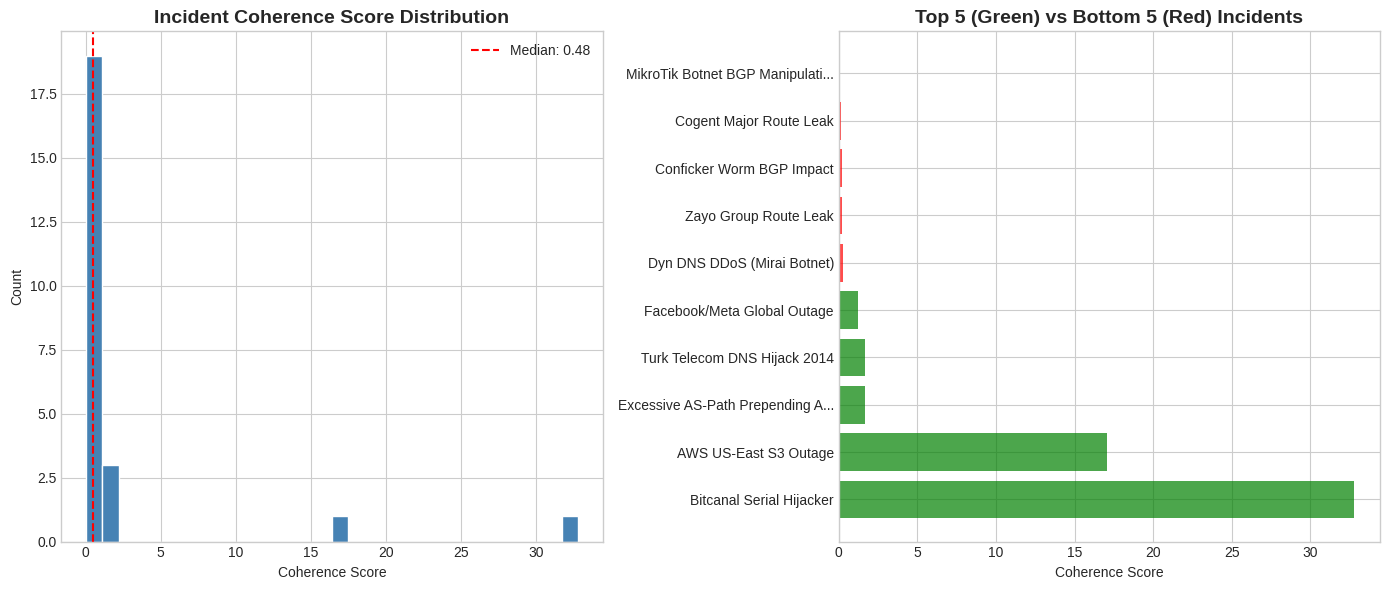

In [18]:
# Visualize coherence scores
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.hist(coherence_df['coherence_score'], bins=30, color='steelblue', edgecolor='white')
ax.axvline(coherence_df['coherence_score'].median(), color='red', linestyle='--', 
           label=f"Median: {coherence_df['coherence_score'].median():.2f}")
ax.set_title('Incident Coherence Score Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Coherence Score')
ax.set_ylabel('Count')
ax.legend()

ax = axes[1]
top_5 = coherence_df.head(5)
bottom_5 = coherence_df.tail(5)
combined = pd.concat([top_5, bottom_5])
colors = ['green']*5 + ['red']*5
y_pos = range(len(combined))
ax.barh(y_pos, combined['coherence_score'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([inc[:30] + '...' if len(inc) > 30 else inc for inc in combined['incident']])
ax.set_xlabel('Coherence Score')
ax.set_title('Top 5 (Green) vs Bottom 5 (Red) Incidents', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/07_incident_coherence.png', dpi=150, bbox_inches='tight')
print(f"Plot saved: {PLOTS_DIR}/07_incident_coherence.png")
plt.show()

---
## 7. Cross-Validation with Supervised Learning

In [19]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_label)

print("Label encoding:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")

Label encoding:
  0: dos_attack
  1: path_manipulation
  2: prefix_hijacking


In [20]:
print("\nTRAINING RANDOM FOREST FOR CROSS-VALIDATION")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

rf = RandomForestClassifier(n_estimators=200, max_depth=20, 
                            random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


TRAINING RANDOM FOREST FOR CROSS-VALIDATION



Classification Report:
                   precision    recall  f1-score   support

       dos_attack       0.97      0.91      0.94     35244
path_manipulation       0.20      0.49      0.29      1647
 prefix_hijacking       0.39      0.46      0.42       227

         accuracy                           0.89     37118
        macro avg       0.52      0.62      0.55     37118
     weighted avg       0.93      0.89      0.91     37118



Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//08_confusion_matrix.png


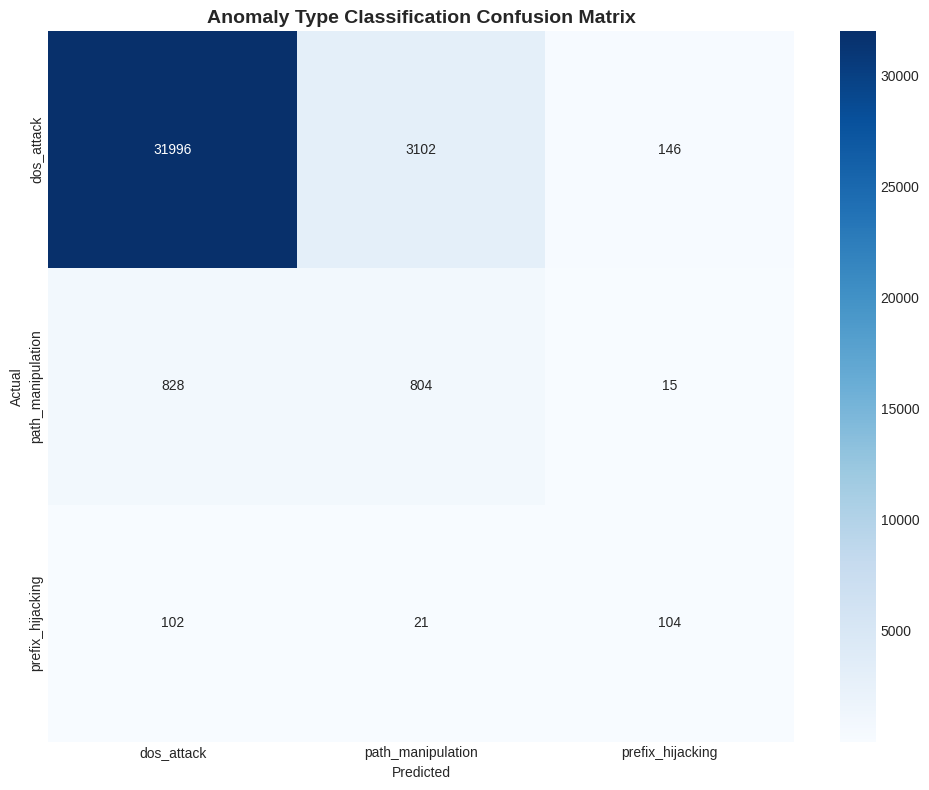

In [21]:
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Anomaly Type Classification Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/08_confusion_matrix.png', dpi=150, bbox_inches='tight')
print(f"Plot saved: {PLOTS_DIR}/08_confusion_matrix.png")
plt.show()

In [22]:
# Get prediction probabilities
proba = rf.predict_proba(X_scaled)
predictions = rf.predict(X_scaled)

mismatch_mask = predictions != y_encoded
print(f"\nSamples with prediction mismatch: {mismatch_mask.sum():,} ({mismatch_mask.sum()/len(y_encoded)*100:.1f}%)")

assigned_proba = proba[np.arange(len(y_encoded)), y_encoded]
low_confidence_mask = assigned_proba < 0.5
print(f"Samples with low classifier confidence (<50%): {low_confidence_mask.sum():,} ({low_confidence_mask.sum()/len(y_encoded)*100:.1f}%)")


Samples with prediction mismatch: 16,816 (9.1%)
Samples with low classifier confidence (<50%): 17,866 (9.6%)



TOP 15 FEATURES FOR ANOMALY TYPE CLASSIFICATION:
           feature  importance
     rare_ases_avg    0.214888
  number_rare_ases    0.136473
       as_path_max    0.101124
          origin_0    0.081174
     announcements    0.074889
          nlri_ann    0.073822
       withdrawals    0.059321
unique_as_path_max    0.054855
          origin_2    0.050703
      imp_wd_spath    0.030411
            imp_wd    0.019360
 edit_distance_avg    0.016929
             nadas    0.015795
      imp_wd_dpath    0.014185
 edit_distance_max    0.013064

Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//09_feature_importance.png


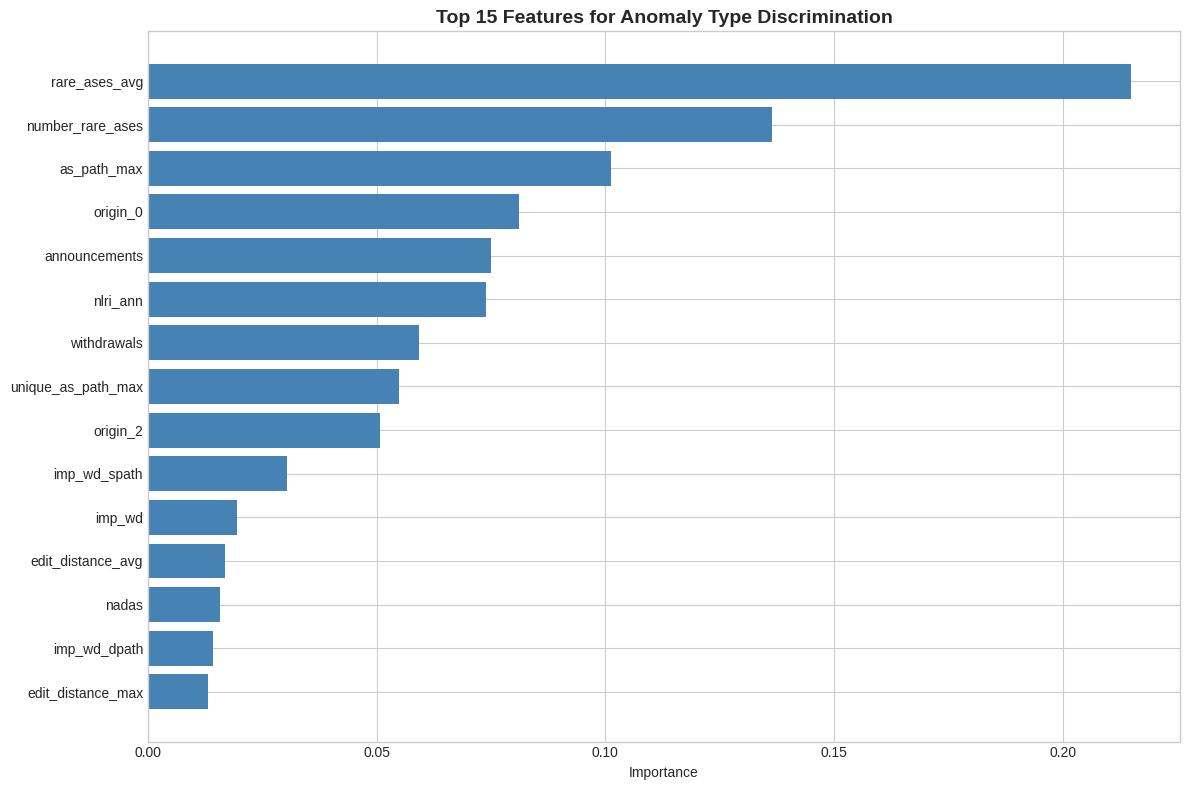

In [23]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 15 FEATURES FOR ANOMALY TYPE CLASSIFICATION:")
print(importance_df.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Features for Anomaly Type Discrimination', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/09_feature_importance.png', dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {PLOTS_DIR}/09_feature_importance.png")
plt.show()

---
## 8. Clustering Validation (HDBSCAN)

In [24]:
print("Performing dimensionality reduction for clustering...")

pca = PCA(n_components=min(10, X_scaled.shape[1]), random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
    X_2d = reducer.fit_transform(X_pca)
    print("UMAP reduction complete.")
else:
    print("Using t-SNE (UMAP not available)...")
    X_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_pca)

Performing dimensionality reduction for clustering...


PCA explained variance: 99.80%
UMAP reduction complete.


In [25]:
print("\nPerforming HDBSCAN clustering...")

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, cluster_selection_epsilon=0.5)
cluster_labels = clusterer.fit_predict(X_pca)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = (cluster_labels == -1).sum()

print(f"Number of clusters found: {n_clusters}")
print(f"Noise points: {n_noise:,} ({n_noise/len(cluster_labels)*100:.1f}%)")


Performing HDBSCAN clustering...
Number of clusters found: 125
Noise points: 56,162 (30.3%)


In [26]:
# Compare clusters with labels
print("\nCLUSTER vs LABEL ALIGNMENT:")
print("="*60)

valid_mask = cluster_labels != -1
if valid_mask.sum() > 100:
    ari = adjusted_rand_score(y_encoded[valid_mask], cluster_labels[valid_mask])
    nmi = normalized_mutual_info_score(y_encoded[valid_mask], cluster_labels[valid_mask])
    print(f"Adjusted Rand Index: {ari:.3f}")
    print(f"Normalized Mutual Information: {nmi:.3f}")

cluster_label_crosstab = pd.crosstab(cluster_labels, y_label, margins=True)
print("\nCluster vs Anomaly Type:")
print(cluster_label_crosstab)


CLUSTER vs LABEL ALIGNMENT:
Adjusted Rand Index: -0.044
Normalized Mutual Information: 0.013

Cluster vs Anomaly Type:
label  dos_attack  path_manipulation  prefix_hijacking     All
row_0                                                         
-1          54375               1354               433   56162
0             638                  0                 0     638
1              79                  0                 0      79
2              67                  1                 1      69
3              57                  0                 0      57
...           ...                ...               ...     ...
121            55                  0                 0      55
122            63                  0                 0      63
123         74396               5779               532   80707
124            62                  2                 0      64
All        176216               8236              1134  185586

[127 rows x 4 columns]


Plot saved: /home/smotaali/BGP_Traffic_Generation/RIPE/plots_extended//10_clustering_visualization.png


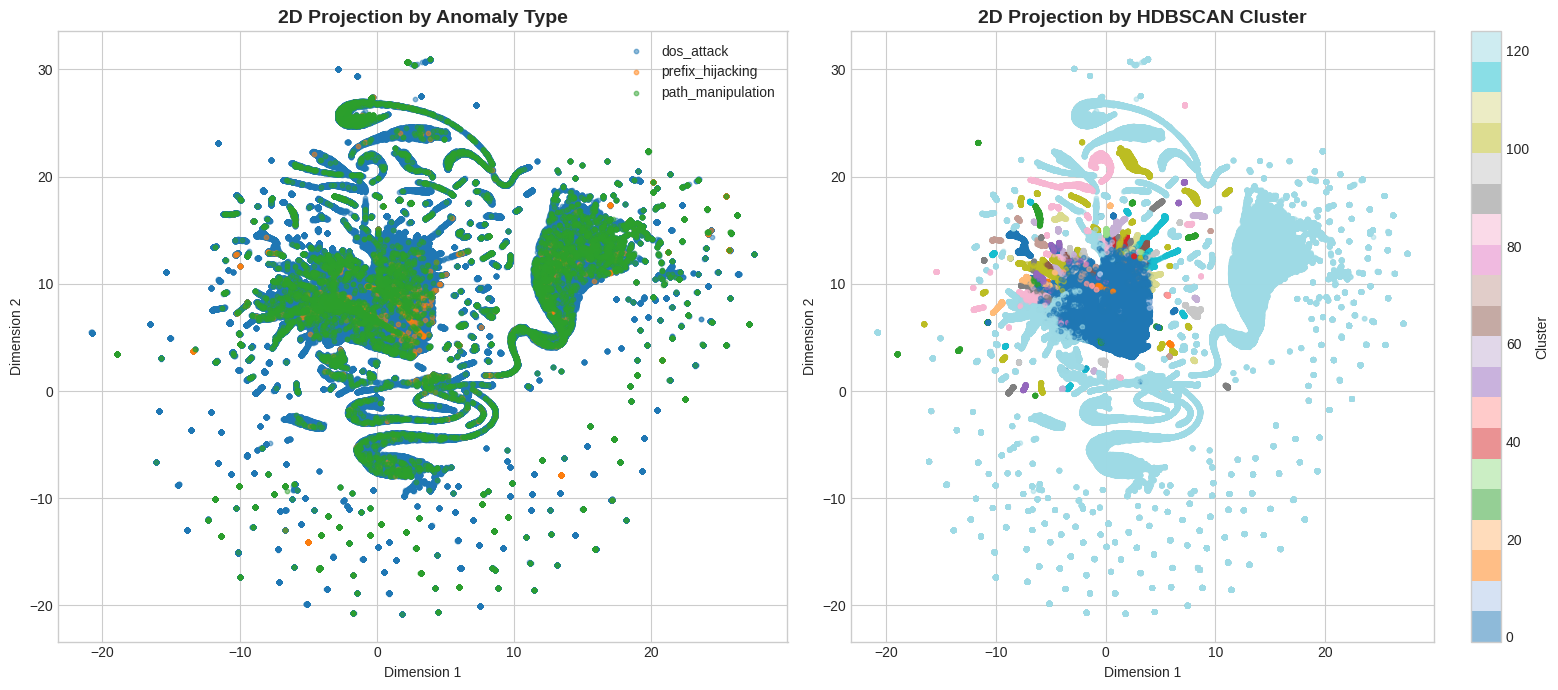

In [27]:
# Visualize clusters vs labels
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax = axes[0]
for label in y_label.unique():
    mask = y_label == label
    ax.scatter(X_2d[mask, 0], X_2d[mask, 1], alpha=0.5, s=10, label=label)
ax.set_title('2D Projection by Anomaly Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

ax = axes[1]
scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab20', alpha=0.5, s=10)
ax.set_title('2D Projection by HDBSCAN Cluster', fontsize=14, fontweight='bold')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/10_clustering_visualization.png', dpi=150, bbox_inches='tight')
print(f"Plot saved: {PLOTS_DIR}/10_clustering_visualization.png")
plt.show()

---
## 9. Final Reinforced Labels and Export

In [28]:
# Build final results dataframe
final_results = pd.DataFrame({
    'original_label': y_label,
    'incident': y_incident,
    'method_agreement': method_agreement,
    'confidence_label': confidence_labels,
    'ensemble_score': ensemble_score,
    'classifier_confidence': proba[np.arange(len(y_encoded)), y_encoded]
})

# Add incident coherence
coherence_map = dict(zip(coherence_df['incident'], coherence_df['coherence_score']))
max_coherence = coherence_df['coherence_score'].max()
final_results['incident_coherence'] = [coherence_map.get(inc, 0) / max_coherence for inc in y_incident]

print("\nFINAL REINFORCEMENT SUMMARY:")
print("="*60)
print(f"Total samples: {len(final_results):,}")
print("\nConfidence distribution:")
for conf, count in final_results['confidence_label'].value_counts().items():
    pct = count / len(final_results) * 100
    print(f"  {conf}: {count:,} ({pct:.1f}%)")


FINAL REINFORCEMENT SUMMARY:
Total samples: 185,586

Confidence distribution:
  needs_review: 157,120 (84.7%)
  low_confidence: 9,668 (5.2%)
  medium_confidence: 7,939 (4.3%)
  very_high_confidence: 7,134 (3.8%)
  high_confidence: 3,725 (2.0%)


In [29]:
# Merge with original data and export
reinforced_df = anomaly_df.copy()

# Add reinforcement columns
reinforced_df['method_agreement_count'] = method_agreement
reinforced_df['reinforced_confidence_label'] = confidence_labels
reinforced_df['ensemble_score'] = ensemble_score
reinforced_df['classifier_confidence'] = proba[np.arange(len(y_encoded)), y_encoded]
reinforced_df['incident_coherence'] = final_results['incident_coherence'].values

# Add individual method scores and flags
for method, scores in all_scores.items():
    reinforced_df[f'score_{method}'] = scores
    reinforced_df[f'flag_{method}'] = scorer.binary_flags[method]

print(f"Reinforced dataset shape: {reinforced_df.shape}")
print(f"New columns added: {len(reinforced_df.columns) - len(anomaly_df.columns)}")

Reinforced dataset shape: (185586, 48)
New columns added: 17


In [31]:
# Save reinforced dataset
output_path = '/home/smotaali/BGP_Traffic_Generation/RIPE/RIPE_INCIDENTS_EXTENDED/all_incidents_anomalies_extended_reinforced.csv'
reinforced_df.to_csv(output_path, index=False)
print(f"\nReinforced dataset saved to: {output_path}")
print(f"File size: {reinforced_df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")


Reinforced dataset saved to: /home/smotaali/BGP_Traffic_Generation/RIPE/RIPE_INCIDENTS_EXTENDED/all_incidents_anomalies_extended_reinforced.csv
File size: 127.22 MB


In [32]:
# Preview
print("\nSample of reinforced dataset:")
reinforced_df[['label', 'Incident', 'method_agreement_count', 
               'reinforced_confidence_label', 'ensemble_score']].head(10)


Sample of reinforced dataset:


,label,Incident,method_agreement_count,reinforced_confidence_label,ensemble_score
0,dos_attack,BGP Route Oscillation Event,1.0,needs_review,0.010248
1,dos_attack,BGP Route Oscillation Event,5.0,very_high_confidence,0.124469
2,dos_attack,BGP Route Oscillation Event,6.0,very_high_confidence,0.460566
3,dos_attack,BGP Route Oscillation Event,0.0,needs_review,0.011134
4,dos_attack,BGP Route Oscillation Event,6.0,very_high_confidence,0.109667
5,dos_attack,BGP Route Oscillation Event,4.0,high_confidence,0.071579
6,dos_attack,BGP Route Oscillation Event,3.0,medium_confidence,0.051697
7,dos_attack,BGP Route Oscillation Event,6.0,very_high_confidence,0.183254
8,dos_attack,BGP Route Oscillation Event,5.0,very_high_confidence,0.080287
9,dos_attack,BGP Route Oscillation Event,4.0,high_confidence,0.042720


---
## 10. Summary Report

In [33]:
from sklearn.metrics import accuracy_score, f1_score

print("\n" + "="*80)
print("BGP ANOMALY LABEL REINFORCEMENT v2 - SUMMARY REPORT")
print("="*80)

print("\n1. DATASET OVERVIEW")
print("-"*40)
print(f"   Total samples: {len(anomaly_df):,}")
print(f"   Anomaly types: {anomaly_df['label'].nunique()}")
print(f"   Unique incidents: {anomaly_df['Incident'].nunique()}")
print(f"   Features used: {len(feature_cols)}")

print("\n2. ANOMALY TYPE DISTRIBUTION")
print("-"*40)
for label, count in anomaly_df['label'].value_counts().items():
    pct = count / len(anomaly_df) * 100
    print(f"   {label}: {count:,} ({pct:.1f}%)")

print("\n3. REINFORCEMENT METHODS USED")
print("-"*40)
print("   1. Mahalanobis Distance from Normal Baseline")
print("   2. One-Class SVM Decision Function")
print("   3. Statistical Z-Score Aggregation")
print("   4. Local Outlier Factor (LOF)")
print("   5. Isolation Forest Anomaly Score")
print("   6. Elliptic Envelope")

print("\n4. METHOD AGREEMENT DISTRIBUTION")
print("-"*40)
for i in range(7):
    count = (method_agreement == i).sum()
    pct = count / len(method_agreement) * 100
    print(f"   {i} methods agree: {count:,} ({pct:.1f}%)")

print("\n5. REINFORCED CONFIDENCE DISTRIBUTION")
print("-"*40)
for conf, count in final_results['confidence_label'].value_counts().items():
    pct = count / len(final_results) * 100
    print(f"   {conf}: {count:,} ({pct:.1f}%)")

print("\n6. CLASSIFIER PERFORMANCE (Random Forest)")
print("-"*40)
print(f"   Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"   Macro F1 Score: {f1_score(y_test, y_pred, average='macro'):.3f}")

print("\n7. CLUSTERING VALIDATION")
print("-"*40)
print(f"   Clusters found: {n_clusters}")
print(f"   Noise points: {n_noise:,} ({n_noise/len(cluster_labels)*100:.1f}%)")
if valid_mask.sum() > 100:
    print(f"   Adjusted Rand Index: {ari:.3f}")
    print(f"   Normalized Mutual Info: {nmi:.3f}")

print("\n8. INCIDENT COHERENCE")
print("-"*40)
print(f"   Mean coherence score: {coherence_df['coherence_score'].mean():.2f}")
print(f"   Median coherence score: {coherence_df['coherence_score'].median():.2f}")
print(f"   Most coherent incident: {coherence_df.iloc[0]['incident']}")

print("\n9. OUTPUT FILES")
print("-"*40)
print(f"   Reinforced dataset: {output_path}")
print(f"   Plots directory: {os.path.abspath(PLOTS_DIR)}")

# List saved plots
print("\n   Saved plots:")
for f in sorted(os.listdir(PLOTS_DIR)):
    if f.endswith('.png'):
        print(f"     - {f}")

print("\n" + "="*80)
print("REINFORCEMENT COMPLETE")
print("="*80)


BGP ANOMALY LABEL REINFORCEMENT v2 - SUMMARY REPORT

1. DATASET OVERVIEW
----------------------------------------
   Total samples: 185,586
   Anomaly types: 3
   Unique incidents: 24
   Features used: 27

2. ANOMALY TYPE DISTRIBUTION
----------------------------------------
   dos_attack: 176,216 (95.0%)
   path_manipulation: 8,236 (4.4%)
   prefix_hijacking: 1,134 (0.6%)

3. REINFORCEMENT METHODS USED
----------------------------------------
   1. Mahalanobis Distance from Normal Baseline
   2. One-Class SVM Decision Function
   3. Statistical Z-Score Aggregation
   4. Local Outlier Factor (LOF)
   5. Isolation Forest Anomaly Score
   6. Elliptic Envelope

4. METHOD AGREEMENT DISTRIBUTION
----------------------------------------
   0 methods agree: 135,999 (73.3%)
   1 methods agree: 21,121 (11.4%)
   2 methods agree: 9,668 (5.2%)
   3 methods agree: 7,939 (4.3%)
   4 methods agree: 3,725 (2.0%)
   5 methods agree: 4,157 (2.2%)
   6 methods agree: 2,977 (1.6%)

5. REINFORCED CONFIDE